# Optimization Methods, PyTorch Lightning

## Introduction
For training neural networks, advanced optimization methods are typically used, which are based on the gradient descent. Today, we will explore how to use them in **PyTorch**, and we'll also go through the **PyTorch Lightning** library, which allows us to reduce the amount of code we have to write in **PyTorch**.

### Plan
1. Optimize a single-variable function in **PyTorch**
2. Explore different optimization methods
3. Work with PyTorch Optimizer
4. Work with PyTorch Scheduler
5. PyTorch VS PyTorch Lightning
6. Compare the performance of different optimizers


In [1]:
!pip3 install pytorch_lightning torchmetrics torchvision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 36.8 MB/s eta 0:00:00


In [2]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    # Fixing maximum seeds for consistency in comparing different experiments
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Optimizing a Single-Variable Function in **PyTorch**

Machine learning methods: parameter search that minimizes the error on the training dataset:
$$
\min_{\theta}L(p_{\theta}(X), Y)
$$
Notations:
* $L$ - some loss function,
* $p_{\theta}$ - neural network with parameters $\theta$,
* $X$ - training data,
* $Y$ - ground truth.

Let's manually write an algorithm to find the minimum of the function $f(x) = x^{3} - 2x^{2} + 2$.


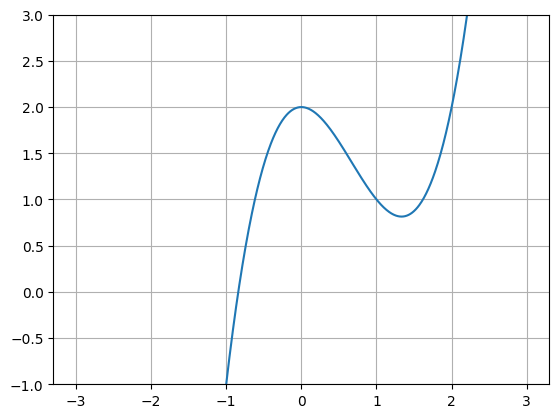

In [4]:
# Our function f(x)
func = lambda x: x**3 - 2 * x**2 + 2
# Derivative of the function f(x)
d_func = lambda x: 3 * x**2 - 4 * x
# Create an array of 1000 elements from -3 to 3
x = np.linspace(-3, 3, 1000)
# Define y-axis limits for the plot
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

Let's define an optimization function for $f(x)$, which should take the learning rate and the maximum number of iterations as inputs.

In [5]:
def find_minimum_first_order(
    learning_rate=0.01, eps=1e-4, max_iterations=1000, anneal_learning_rate=None
):
    i = 0
    x_old, x_new = 0, 2
    # We will keep a history of x and y values
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr
    # TODO:
    # Your code here
    # --------------
    while abs(x_new - x_old) > eps and i < max_iterations:
        # Get the learning rate for the current iteration
        learning_rate = anneal_learning_rate(learning_rate, step=i)
        # Update x_old
        x_old = x_new
        # Take one step of gradient descent
        x_new = x_old - learning_rate * d_func(x_old)
        # Add new values for visualization of convergence
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Found local minimum:", x_new)
    print("Number of steps:", len(x_list))
    # Visualize the convergence
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors="k")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()


Try different learning rates and observe optimization behavior


Found local minimum: 1.3577577123861129
Number of steps: 729


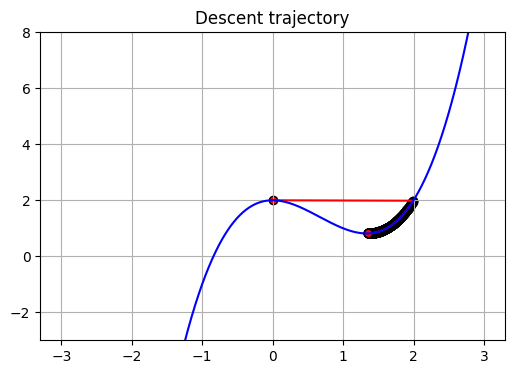

In [6]:
find_minimum_first_order(0.001)

Too small; we will be going very slowly towards the local minimum

Found local minimum: 1.3356881625009205
Number of steps: 129


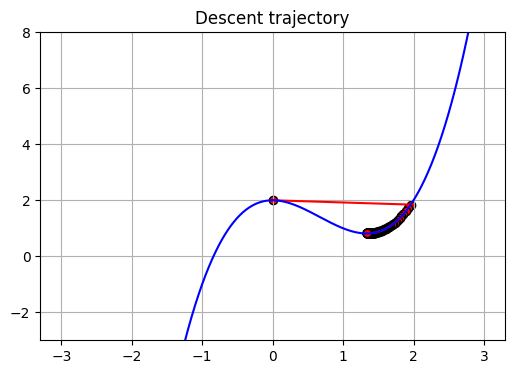

In [7]:
find_minimum_first_order(0.01)

We got better results.

Found local minimum: 1.3333495713163788
Number of steps: 8


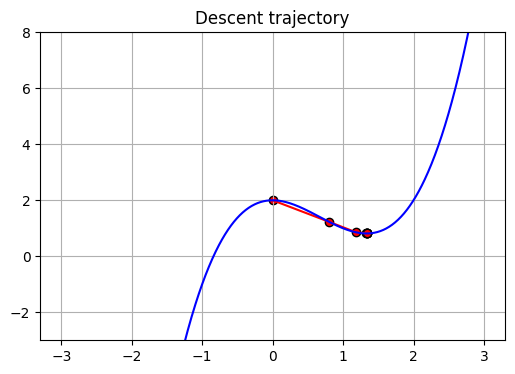

In [8]:
find_minimum_first_order(0.3)

In [9]:
find_minimum_first_order(0.6)

OverflowError: (34, 'Numerical result out of range')

Oops, we got an Overflow. This means the learning rate is too large. Although a large learning rate carries the risk of overflow, it has several advantages. The larger the learning rate, the greater the distances we cover in one step, and the higher the probability of quickly finding a good region of local minima.

A good strategy is to start with a sufficiently large step (to explore the function well) and then gradually decrease it to stabilize the learning process in some local minimum.

Found local minimum: 1.294744839667743
Number of steps: 7


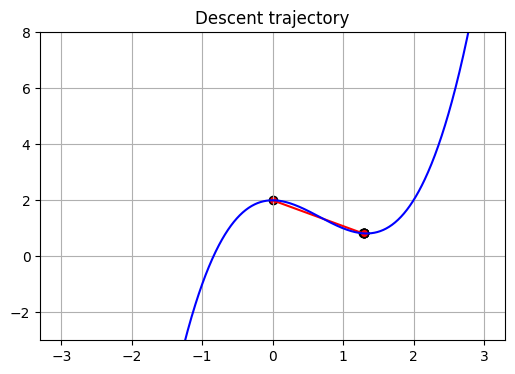

In [10]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

## Exploring Different Optimization Methods

### Stochastic Gradient Descent
SGD is the same gradient descent we discussed earlier, but the gradients are calculated not over the entire dataset but over a randomly chosen sample. Obviously, such optimization will be very noisy, making model training more challenging. Therefore, MiniBatch-SGD is usually used, where instead of a single sample, we take $k$. This approach has lower variance compared to regular SGD, leading to a more stable optimization process. At the same time, we still don't need to work with the entire dataset simultaneously, allowing us to control memory usage.

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### Stochastic Gradient Descent with Momentum
Let's try to add the effect of inertia to SGD. Now, instead of moving in the gradient direction at each point, we try to continue moving in the same direction as before. So, our point descending along a multi-dimensional surface gains momentum, controlled by the parameter $\alpha$. It determines what part of the previous gradient we want to use at the current step.

$$
\begin{eqnarray}
g_{t} &=& \alpha g_{t-1} + \eta \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

![Momentum](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/04/gradient_descent_variations_momentum.png?lossy=2&strip=1&webp=1)

### Adaptive Variants of Gradient Descent
In all previous algorithms, we had a fixed learning rate. Starting from Adagrad, we will consider algorithms that adjust the learning rate based on training. They are called adaptive variants of gradient descent.

Adaptive variants of gradient descent adjust the learning rate to make large or small updates for individual parameters. For example, it may happen that some weights are close to their local minima, so we need to move slower along these coordinates, while other weights are still far from the local minima, so we can update them much faster. Such methods often lead to a more justified model and converge much faster.

#### Adagrad
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& s + \text{diag}(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+\epsilon}} \odot g
\end{eqnarray}
$$
Now we don't need to worry too much about the right choice of $\eta$, since $s$ controls the learning rate for each parameter.

#### RMSprop
Adagrad has a significant drawback. $s$ is always positive and constantly grows during training, leading to a situation where our learning rate becomes too small, and we stop learning. RMSprop fixes this issue using exponential smoothing:

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& \rho s + (1 - \rho) \text{diag}(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+\epsilon}} \odot g
\end{eqnarray}
$$

#### Adam
Let's add not only second-order moments but also the first order when updating parameters:

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) \text{diag}(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$




### Working with PyTorch Optimizer

Obviously, for your neural networks, you don't need to write your algorithm every time, as all the most popular methods have already been implemented for you. You can find them in **torch.optim** or [here](https://pytorch.org/docs/stable/optim.html#algorithms).


In [11]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

Main PyTorch Optimizer methods:
* __step__ - update the model weights
* __zero_grad__ - zero out the model weights (by default, gradients in PyTorch accumulate) ~ `for each param in params: param.grad = None`
* __state_dict__ - get the current state of the Optimizer. For adaptive methods, accumulated squares of gradients will be stored here.

### How to create a PyTorch Optimizer instance?

To create an optimizer instance, you just need to pass it the model parameters (which you can get using the `parameters()` function) and hyperparameters for the optimization method.

Example:

In [12]:
?torch.optim.SGD

In [13]:
model = torch.nn.Linear(1, 1)
list(model.named_parameters()), torch.optim.SGD(model.parameters(), lr=0.01)

([('weight',
   Parameter containing:
   tensor([[-0.1194]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0.4259], requires_grad=True))],
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Or:

In [14]:
# Define PyTorch modules as a dictionary
model = torch.nn.ModuleDict(
    {"linear_1": torch.nn.Linear(1, 1), "linear_2": torch.nn.Linear(2, 2)}
)
torch.optim.SGD(
    [
        {"params": model["linear_1"].parameters(), "lr": 0.3},
        {"params": model["linear_2"].parameters()},
    ],
    lr=0.5,
)


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.3
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.5
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

The last point is very useful, for example, in transfer learning when we want the pre-trained model to be trained with a different learning rate.

**Important:** even if you have adaptive gradient descent methods, it's not advisable to completely forget about tuning the learning rate.


### Working with PyTorch Scheduler

At the beginning of the seminar, we reduced the number of steps to convergence as follows: started with a sufficiently large learning rate, and then gradually reduced it to stabilize the learning process in the minimum. It turns out there are many ways to modify optimization in this way. They are called Schedulers.


In [15]:
[elem for elem in dir(torch.optim.lr_scheduler) if not elem.startswith("_")]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 'bisect_right',
 'inf',
 'math',
 'partial',
 'types',
 'warnings',
 'weakref',
 'wraps']

### Main methods of PyTorch Scheduler:
* __step__ - update the learning rate. *Usually called **once per epoch**, not every optimizer step.*
* __state_dict__ - get the current state of the Scheduler: current LR, the number of steps passed, and additional parameters.

### How to create a PyTorch Scheduler instance?

It is enough to pass `optimizer` and hyperparameters for the method.

Example:


In [16]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_func = lambda epoch: 0.65**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

Let's create a couple of small functions for visualizing the learning rate changes using different schedulers:

In [17]:
def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.SGD(model.parameters(), lr=100)
    return simple_model, simple_optimizer


def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(100), lrs)

### Examples of Various Schedulers in **PyTorch**

#### Lambda LR
Multiplies the learning rate by the value of the given function: $lr_{\text{epoch}} = lr_{\text{initial}} \times \text{Lambda(epoch)}$.


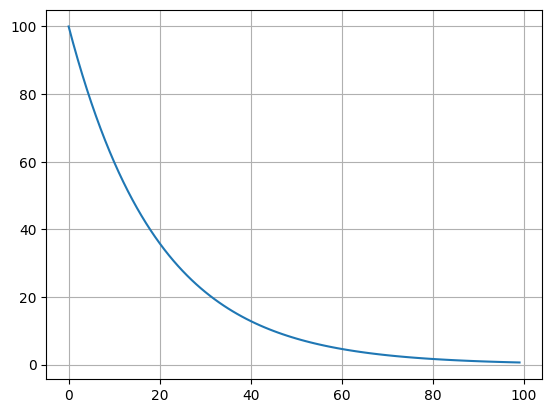

In [18]:
model, optimizer = get_simple_model_optimizer()
lambda_func = lambda epoch: 0.95**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
draw_learning_rate_curve(optimizer, scheduler)

#### StepLR
Reduces the learning rate by a factor of `gamma` every `step_size` epochs.


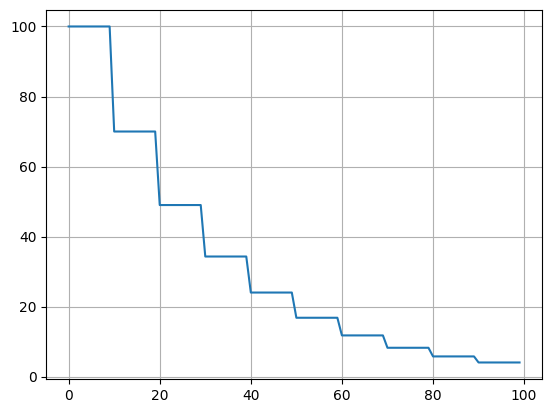

In [19]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
draw_learning_rate_curve(optimizer, scheduler)

#### CosineAnnealingLR

It is important to understand that learning rate (LR) makes sense not only to decrease but sometimes also to make cyclic. The formula [here](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html) is somewhat more complex, we'll leave it for those who are interested.


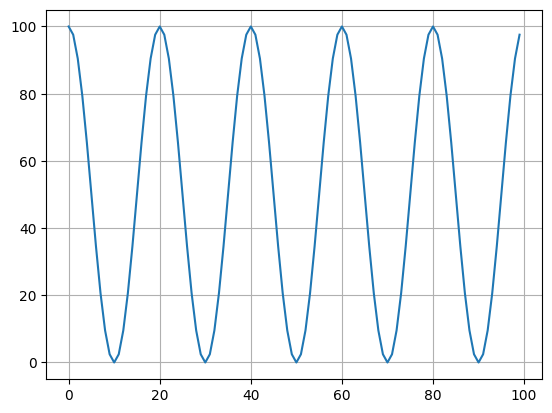

In [20]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
draw_learning_rate_curve(optimizer, scheduler)

## PyTorch vs. PyTorch Lightning

**PyTorch Lightning** is a framework for organized work with **PyTorch**. It simplifies tasks such as:
- Writing the training loop
- Creating datasets
- Utilizing GPU/TPU/IPU/HPU, etc.
- Converting models to the ONNX format
- And much more

The framework aims to allow users to configure parameters and conduct experiments, while it takes care of the rest. Let's compare code in **PyTorch** without and with the use of **Lightning**, using a simple neural network on the FashionMNIST dataset as an example.


In [21]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# A powerful library with a variety of metrics out of the box
from torchmetrics.functional import accuracy

### Data

In [22]:
# Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

100%|██████████| 26421880/26421880 [00:01<00:00, 15524763.45it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265865.92it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4902398.17it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5736524.17it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

Ankle Boot


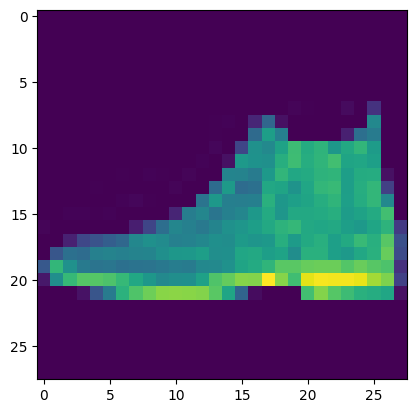

Coat


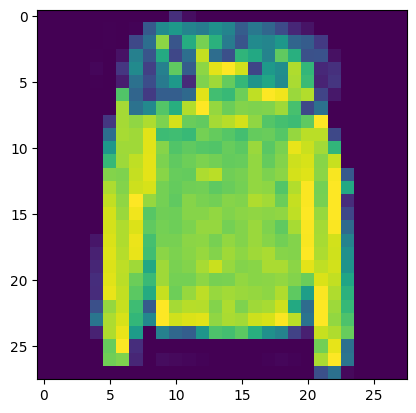

In [24]:
### pictures are normalized
for batch in val_dataloader:
    # batch_size is 128
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()
    print(idx_to_label[int(class_nums[127])])
    plt.imshow(images[127].squeeze())
    plt.show()
    break

### Model (General)

Create a model class according to the following architecture:

1. BatchNorm
2. Conv(out=32, kernel=3) -> ReLU -> MaxPool(kernel=2)
3. BatchNorm
4. Conv(out=64, kernel=3) -> ReLU -> MaxPool(kernel=2)
5. Flatten
6. Linear(out=128)
7. ReLU
8. Dropout
9. Linear(out=64)
10. ReLU
11. Linear(out=10)


In [25]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # TODO:
        # Your code here:
        # --------------
        self.batch_norm1 = torch.nn.BatchNorm2d(1)

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)

        self.output = torch.nn.Linear(in_features=64, out_features=10)

        self.dropout = torch.nn.Dropout(p=dropout)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        # TODO:
        # Your code here
        # --------------
        x = self.batch_norm1(x)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)
        # --------------

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=10)

        return loss

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy


### Hyper-parameters

In [26]:
LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

### Training Loops (PyTorch)

Here, we need to define the functions `train_epoch`, `validate`, `fit`.
The structure, simplified, looks like this:

```
def train_epoch():
    for batch in train_loader:
        train_model_on_batch()
def validate():
    for batch in val_loader:
        validate_model_on_batch()
def fit():
    for epoch in range(1, num_epochs):
        train_epoch()
        validate()
```
But in reality:

In [27]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

In [28]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [29]:
# Check that everything works (±1 minute on GPU):
model = SimpleNet().to(device)
_ = fit(
    model=model,
    epochs=1,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.1802 Accuracy: 24.51: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
Validation Epoch: 0
Loss: 2.1559 Accuracy: 52.2: 100%|██████████| 79/79 [00:01<00:00, 56.79it/s]


# Training Loops (Lightning)

Here, the structure is a bit different.

1) Create a class inherited from `pl.LightningModule`. It describes the model itself and the necessary training and validation step functions.

2) Create an object of the `pl.Trainer` class with parameters (e.g., GPU number, number of epochs, gradient clipping, and so on) [docs here](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer) or [here](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=trainer#trainer-flags).

3) Call `trainer.fit(model, train_loader, val_loader)`.

```python
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)


In [30]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )  # Saves logs to a folder, but it can be easily extended to include WandB.
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

In [31]:
# 2) create module

model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer(accelerator="cpu", max_epochs=1)
trainer.fit(module, train_dataloader, val_dataloader)

# 3.5) we can also find best learning rate like this: https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html
# trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)
# trainer.tune(module, train_dataloader, eval_dataloader)
# trainer.fit(module, train_dataloader, eval_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | SimpleNet | 232 K 
------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Take note of how much the behavior of `trainer.fit()` closely resembles the `fit()` function we wrote earlier.

Also, observe that with Lightning, we:
1. Didn't have to describe the training loop either by epochs or batches.
2. Didn't risk forgetting `zero_grad()` and `.backward()`.
3. Didn't need to manually move either the model or the data to the GPU.
4. Gained additional features like `auto_lr_find`.
5. Preserved the ability to use various PyTorch features such as [schedulers](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html), logging via [WandB](https://docs.wandb.ai/guides/integrations/lightning), and so on.


## Comparing the performance of different optimizers

### SGD

In [32]:
model = SimpleNet().to(device=device)
sgd_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.1647 Accuracy: 19.2667: 100%|██████████| 469/469 [00:11<00:00, 42.48it/s]
Validation Epoch: 0
Loss: 2.1582 Accuracy: 33.78: 100%|██████████| 79/79 [00:01<00:00, 53.75it/s]
Train Epoch: 1
Loss: 1.927 Accuracy: 33.1767: 100%|██████████| 469/469 [00:10<00:00, 42.71it/s]
Validation Epoch: 1
Loss: 1.8123 Accuracy: 40.0: 100%|██████████| 79/79 [00:01<00:00, 56.06it/s]
Train Epoch: 2
Loss: 1.4946 Accuracy: 44.4317: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s]
Validation Epoch: 2
Loss: 1.3498 Accuracy: 59.99: 100%|██████████| 79/79 [00:01<00:00, 55.98it/s]
Train Epoch: 3
Loss: 1.107 Accuracy: 57.7383: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
Validation Epoch: 3
Loss: 0.9596 Accuracy: 69.17: 100%|██████████| 79/79 [00:02<00:00, 38.02it/s]
Train Epoch: 4
Loss: 1.1131 Accuracy: 64.1467: 100%|██████████| 469/469 [00:10<00:00, 43.00it/s]
Validation Epoch: 4
Loss: 0.7165 Accuracy: 72.01: 100%|██████████| 79/79 [00:01<00:00, 55.82it/s]
Train Epoch: 5
Loss: 0.8616 

### SGD with Momentum

In [33]:
model = SimpleNet().to(device=device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.6253 Accuracy: 53.2217: 100%|██████████| 469/469 [00:11<00:00, 41.81it/s]
Validation Epoch: 0
Loss: 0.4694 Accuracy: 74.21: 100%|██████████| 79/79 [00:01<00:00, 56.81it/s]
Train Epoch: 1
Loss: 0.547 Accuracy: 75.48: 100%|██████████| 469/469 [00:11<00:00, 42.50it/s]
Validation Epoch: 1
Loss: 0.3557 Accuracy: 78.15: 100%|██████████| 79/79 [00:01<00:00, 55.28it/s]
Train Epoch: 2
Loss: 0.5023 Accuracy: 79.2833: 100%|██████████| 469/469 [00:11<00:00, 41.64it/s]
Validation Epoch: 2
Loss: 0.262 Accuracy: 81.43: 100%|██████████| 79/79 [00:01<00:00, 56.72it/s]
Train Epoch: 3
Loss: 0.4183 Accuracy: 81.7333: 100%|██████████| 469/469 [00:11<00:00, 42.52it/s]
Validation Epoch: 3
Loss: 0.23 Accuracy: 82.99: 100%|██████████| 79/79 [00:01<00:00, 56.49it/s]
Train Epoch: 4
Loss: 0.3282 Accuracy: 83.72: 100%|██████████| 469/469 [00:11<00:00, 42.05it/s]
Validation Epoch: 4
Loss: 0.1842 Accuracy: 84.73: 100%|██████████| 79/79 [00:01<00:00, 55.92it/s]
Train Epoch: 5
Loss: 0.3619 Accur

### RMSprop

In [34]:
model = SimpleNet().to(device=device)
rmsprop_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.3042 Accuracy: 78.8317: 100%|██████████| 469/469 [00:11<00:00, 41.50it/s]
Validation Epoch: 0
Loss: 0.1285 Accuracy: 86.98: 100%|██████████| 79/79 [00:01<00:00, 55.13it/s]
Train Epoch: 1
Loss: 0.552 Accuracy: 86.2383: 100%|██████████| 469/469 [00:11<00:00, 42.11it/s]
Validation Epoch: 1
Loss: 0.1608 Accuracy: 88.0: 100%|██████████| 79/79 [00:01<00:00, 55.29it/s]
Train Epoch: 2
Loss: 0.3752 Accuracy: 88.0167: 100%|██████████| 469/469 [00:11<00:00, 41.45it/s]
Validation Epoch: 2
Loss: 0.0901 Accuracy: 88.12: 100%|██████████| 79/79 [00:01<00:00, 54.28it/s]
Train Epoch: 3
Loss: 0.318 Accuracy: 88.9917: 100%|██████████| 469/469 [00:11<00:00, 42.00it/s]
Validation Epoch: 3
Loss: 0.0833 Accuracy: 88.4: 100%|██████████| 79/79 [00:01<00:00, 55.33it/s]
Train Epoch: 4
Loss: 0.2372 Accuracy: 89.8317: 100%|██████████| 469/469 [00:11<00:00, 42.05it/s]
Validation Epoch: 4
Loss: 0.0354 Accuracy: 90.06: 100%|██████████| 79/79 [00:01<00:00, 51.97it/s]
Train Epoch: 5
Loss: 0.1298 A

### Adam

In [35]:
model = SimpleNet().to(device=device)
adam_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.413 Accuracy: 80.4467: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s]
Validation Epoch: 0
Loss: 0.1534 Accuracy: 87.01: 100%|██████████| 79/79 [00:01<00:00, 44.69it/s]
Train Epoch: 1
Loss: 0.2899 Accuracy: 87.6133: 100%|██████████| 469/469 [00:10<00:00, 43.87it/s]
Validation Epoch: 1
Loss: 0.1165 Accuracy: 88.83: 100%|██████████| 79/79 [00:01<00:00, 42.54it/s]
Train Epoch: 2
Loss: 0.1756 Accuracy: 89.0433: 100%|██████████| 469/469 [00:10<00:00, 43.50it/s]
Validation Epoch: 2
Loss: 0.1144 Accuracy: 90.11: 100%|██████████| 79/79 [00:01<00:00, 42.79it/s]
Train Epoch: 3
Loss: 0.212 Accuracy: 90.22: 100%|██████████| 469/469 [00:10<00:00, 43.87it/s]
Validation Epoch: 3
Loss: 0.0993 Accuracy: 90.34: 100%|██████████| 79/79 [00:01<00:00, 41.62it/s]
Train Epoch: 4
Loss: 0.3496 Accuracy: 91.1683: 100%|██████████| 469/469 [00:10<00:00, 43.39it/s]
Validation Epoch: 4
Loss: 0.2033 Accuracy: 90.37: 100%|██████████| 79/79 [00:01<00:00, 41.80it/s]
Train Epoch: 5
Loss: 0.1702 A

### Adam + Scheduler

In [36]:
model = SimpleNet().to(device=device)
lambda_func = lambda epoch: 0.975**epoch
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
adam_scheduler_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

Train Epoch: 0
Loss: 0.465 Accuracy: 80.945: 100%|██████████| 469/469 [00:10<00:00, 44.05it/s]
Validation Epoch: 0
Loss: 0.2028 Accuracy: 87.65: 100%|██████████| 79/79 [00:01<00:00, 40.06it/s]
Train Epoch: 1
Loss: 0.3579 Accuracy: 87.765: 100%|██████████| 469/469 [00:10<00:00, 43.53it/s]
Validation Epoch: 1
Loss: 0.1432 Accuracy: 89.07: 100%|██████████| 79/79 [00:01<00:00, 39.94it/s]
Train Epoch: 2
Loss: 0.307 Accuracy: 89.175: 100%|██████████| 469/469 [00:10<00:00, 44.26it/s]
Validation Epoch: 2
Loss: 0.0909 Accuracy: 89.85: 100%|██████████| 79/79 [00:02<00:00, 39.04it/s]
Train Epoch: 3
Loss: 0.2894 Accuracy: 90.3017: 100%|██████████| 469/469 [00:10<00:00, 44.22it/s]
Validation Epoch: 3
Loss: 0.0421 Accuracy: 90.3: 100%|██████████| 79/79 [00:02<00:00, 37.90it/s]
Train Epoch: 4
Loss: 0.2481 Accuracy: 91.2533: 100%|██████████| 469/469 [00:10<00:00, 44.64it/s]
Validation Epoch: 4
Loss: 0.0464 Accuracy: 90.21: 100%|██████████| 79/79 [00:02<00:00, 37.86it/s]
Train Epoch: 5
Loss: 0.2507 Acc

On validation, the performance is somewhat better than with just Adam.


### Loss Decline Plots with Different Optimization Methods

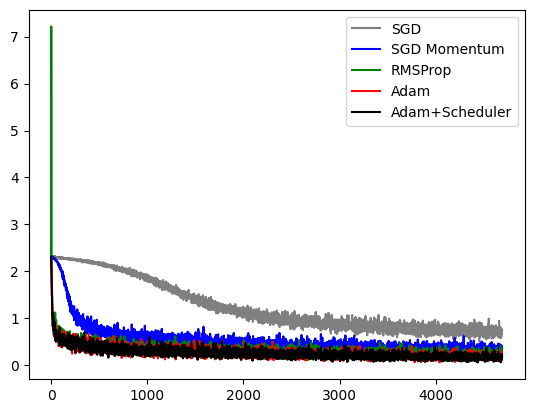

In [37]:
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_loss_info.full_train_losses,
    label="SGD",
    c="grey",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_momentum_loss_info.full_train_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    rmsprop_loss_info.full_train_losses,
    label="RMSProp",
    c="green",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_loss_info.full_train_losses,
    label="Adam",
    c="red",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_scheduler_loss_info.full_train_losses,
    label="Adam+Scheduler",
    c="black",
)

plt.legend()
plt.show()

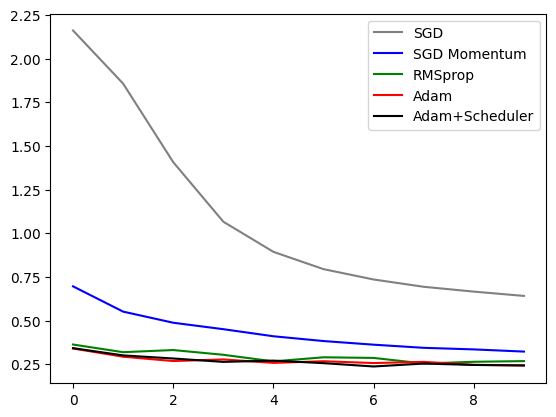

In [38]:
plt.plot(np.arange(10), sgd_loss_info.eval_epoch_losses, label="SGD", c="grey")
plt.plot(
    np.arange(10),
    sgd_momentum_loss_info.eval_epoch_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(np.arange(10), rmsprop_loss_info.eval_epoch_losses, label="RMSprop", c="green")
plt.plot(np.arange(10), adam_loss_info.eval_epoch_losses, label="Adam", c="red")
plt.plot(
    np.arange(10),
    adam_scheduler_loss_info.eval_epoch_losses,
    label="Adam+Scheduler",
    c="black",
)
plt.legend()
plt.show()